# Problem Set solution, implemented using a matrix representation and with good documentation

In [5]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import math
import pprint

In [50]:
# bin the spiks by their associated stims
def associate_spiks_to_stims(spiks, stims, dt):
    max_stim = len(stims) * dt
    # put a tiny amount of extra time at the end of the bin to make sure that we include the extreme times
    epsilon = dt / 2
    return np.histogram(spiks, bins=np.arange(0, max_stim+epsilon, dt), range=(0, max_stim))[0]


# combine the spiks and stims by as columns
def merge_spiks_and_stims(spiks, stims, dt):
    spiks_per_stim = associate_spiks_to_stims(spiks, stims, dt)
    return np.column_stack([stims.flatten(), spiks_per_stim])


# shifts vector by the amount (shift can be positive or negative)
# fills the empty elements with zeros
def shift_vector(vector, shift):
    if shift > len(vector):
        shift = len(vector)
    elif shift < 0 and abs(shift) > len(vector):
        shift = -len(vector)
    
    if shift > 0:
        shifted = np.concatenate((np.zeros((shift)), vector[:-shift]), axis=None)
    elif shift < 0:
        shifted = np.concatenate((vector[abs(shift):], np.zeros((abs(shift)))), axis=None)
    else:
        shifted = vector
    
    return shifted


def calc_sta(merged, num_lags):
    sta = []
    for lag in range(0, num_lags):
        lagged_stim = shift_vector(merged[:,0], lag)
        sta.append(np.sum(lagged_stim * merged[:,1]) / np.sum(merged[:,1]))
    sta = np.array(sta)
    return sta


def g_convolve(s, k):
    # pad to make causal
    k2 = np.zeros(len(k)*2-1)
    k2[len(k)-1:] = [i for i in k] # reverse the kernel before convolving it with s
    g = np.convolve(s, k2, mode='same')
    return g


def nl_func(nl, g_stim):
    x = np.arange(-6, 6, 0.2)
    # find the closest nl value for the given g_stim
    for i in range(len(x)-1):
        if g_stim >= x[i] and g_stim < x[i+1]:
            return nl[i]
    return -1

## Load the data

In [51]:
# 1. load the data
d = loadmat('LGN_FFdata.mat')

spiks = d['FFspks'][0].flatten() # number is number of seconds from the start for that spike
stims = d['FFstim'].flatten() # the stimlus value at the time step
dt = d['DTstim'][0].flatten() # time between each stimulus

## Put the data into a matrix form to make manipulating it easier

In [52]:
# make a matrix: NT x lags
# 2. calculate the STA for the neuron --> g()
merged = merge_spiks_and_stims(spiks, stims, dt)
merged

array([[-1.66558397,  0.        ],
       [ 0.125332  ,  0.        ],
       [ 0.28767601,  0.        ],
       ...,
       [-0.72446799,  0.        ],
       [-0.068865  ,  0.        ],
       [ 0.        ,  1.        ]])

In [60]:
# shift the stimulus vector over by each lag to construct the time embedding
num_lags = 12
# embedding matrix is NxL (N = number of trials (i.e. len of stimulus), L = number of lags to use)
embedding = np.zeros((len(stims), num_lags)) # add an extra column for the stims
for lag in range(0, num_lags):
    lagged_stim = shift_vector(stims, lag)
    embedding[:,lag] = lagged_stim.T # put the shifted stimulus in the lag column
    #embedding[:,lag] = merge_spiks_and_stims(spiks, lagged_stim, dt)[:,1]

In [64]:
response = merge_spiks_and_stims(spiks, stims, dt)[:,1]

In [61]:
embedding[:,0] == stims

array([ True,  True,  True, ...,  True,  True,  True])

In [69]:
response.shape, embedding.shape

((14391,), (14391, 12))

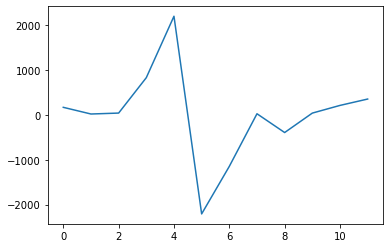

In [71]:
plt.plot(np.matmul(embedding.T, response))